In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.preprocessing import  MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import warnings

In [2]:
warnings.simplefilter('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Preparation

In [4]:
data = pd.read_csv(f'data/MSFT.csv')
data = data[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'])
data

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9600,2024-04-17,411.839996
9601,2024-04-18,404.269989
9602,2024-04-19,399.119995
9603,2024-04-22,400.959991


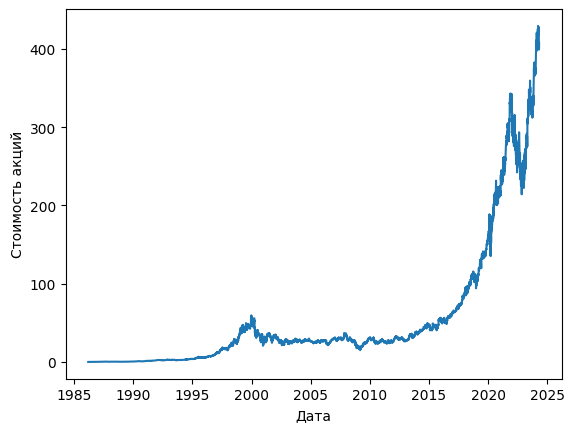

In [5]:
plt.plot(data['Date'], data['Close']);
plt.xlabel('Дата')
plt.ylabel('Стоимость акций')
plt.show()

In [6]:
# Функция для подготовки данных к lstm
def preparee_dataframe_for_lstm(df, n_steps):
    df = deepcopy(df)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    for i in range(n_steps, 0, -1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    return df.dropna()

In [7]:
window = 14 # Размер окна, число дней по которым будет предсказывать соимость в следующем дне
windowed_data = preparee_dataframe_for_lstm(data, window)
windowed_data

,Close,Close(t-14),Close(t-13),Close(t-12),Close(t-11),Close(t-10),Close(t-9),Close(t-8),Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1)
Date,,,,,,,,,,,,,,,
1986-04-03,0.096354,0.097222,0.100694,0.102431,0.099826,0.098090,0.095486,0.092882,0.090278,0.092014,0.094618,0.096354,0.095486,0.094618,0.095486
1986-04-04,0.096354,0.100694,0.102431,0.099826,0.098090,0.095486,0.092882,0.090278,0.092014,0.094618,0.096354,0.095486,0.094618,0.095486,0.096354
1986-04-07,0.094618,0.102431,0.099826,0.098090,0.095486,0.092882,0.090278,0.092014,0.094618,0.096354,0.095486,0.094618,0.095486,0.096354,0.096354
1986-04-08,0.095486,0.099826,0.098090,0.095486,0.092882,0.090278,0.092014,0.094618,0.096354,0.095486,0.094618,0.095486,0.096354,0.096354,0.094618
1986-04-09,0.097222,0.098090,0.095486,0.092882,0.090278,0.092014,0.094618,0.096354,0.095486,0.094618,0.095486,0.096354,0.096354,0.094618,0.095486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-17,411.839996,421.429993,420.720001,424.570007,421.440002,420.450012,417.880005,425.519989,424.589996,426.279999,423.260010,427.929993,421.899994,413.640015,414.579987
2024-04-18,404.269989,420.720001,424.570007,421.440002,420.450012,417.880005,425.519989,424.589996,426.279999,423.260010,427.929993,421.899994,413.640015,414.579987,411.839996
2024-04-19,399.119995,424.570007,421.440002,420.450012,417.880005,425.519989,424.589996,426.279999,423.260010,427.929993,421.899994,413.640015,414.579987,411.839996,404.269989


In [8]:
# Произведем рамасштабирование данных
scaler = MinMaxScaler(feature_range=(-1, 1))

windowed_scale_data = scaler.fit_transform(windowed_data)

In [9]:
# Выделение фичей и таргета
X = windowed_scale_data[:, 1:]
y = windowed_scale_data[:, 0]

# Разбиение на тренировочную и тестовую выбоку
split_index = int(len(X) * 0.95)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9111, 14), (480, 14), (9111,), (480,))

In [10]:
# Преобразование данных к тензорам
X_train = torch.tensor(X_train[:, :, None]).to(torch.float32)
X_test = torch.tensor(X_test[:, :, None]).to(torch.float32)
y_train = torch.tensor(y_train[:, None]).to(torch.float32)
y_test = torch.tensor(y_test[:, None]).to(torch.float32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([9111, 14, 1]),
 torch.Size([480, 14, 1]),
 torch.Size([9111, 1]),
 torch.Size([480, 1]))

In [11]:
# Датасет для временных рядов
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

# Создание даталоадеров
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
for i, batch in enumerate(train_loader, start=1):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(f'epoch #{i} x_batch: {x_batch.shape}, y_batch:{y_batch.shape}')
    if i == 5:
        print('...')
        break

epoch #1 x_batch: torch.Size([16, 14, 1]), y_batch:torch.Size([16, 1])
epoch #2 x_batch: torch.Size([16, 14, 1]), y_batch:torch.Size([16, 1])
epoch #3 x_batch: torch.Size([16, 14, 1]), y_batch:torch.Size([16, 1])
epoch #4 x_batch: torch.Size([16, 14, 1]), y_batch:torch.Size([16, 1])
epoch #5 x_batch: torch.Size([16, 14, 1]), y_batch:torch.Size([16, 1])
...


# Modeling

In [13]:
# Создание модели
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(
            input_size=input_size, # The number of expected features in the input x
            hidden_size=hidden_size, # The number of features in the hidden state h
            num_layers=num_stacked_layers, # Number of recurrent layers.
            batch_first=True #  If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature)
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [14]:
# Функция для обучения одной эпохи
def train_one_epoch():
    model.train()
    print(f'Epoch: {epoch+1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99: # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print(f'Batch {batch_index + 1}, loss: {avg_loss_across_batches}')
            running_loss = 0.0
    print()

In [15]:
# Функция для валидации одной эпохи
def validate_one_epoch():
    model.eval()
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    print(f'Val Loss: {avg_loss_across_batches}')
    print('*'*50)
    print()

In [16]:
# Обучение модели
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, loss: 0.1944146066531539
Batch 200, loss: 0.06248235567472875
Batch 300, loss: 0.044432010122109206
Batch 400, loss: 0.026388205570401623
Batch 500, loss: 0.015281225799699314

Val Loss: 0.2754827953875065
**************************************************

Epoch: 2
Batch 100, loss: 0.004423463287384948
Batch 200, loss: 0.0037416390562430026
Batch 300, loss: 0.00242770210323215
Batch 400, loss: 0.0018987023561930982
Batch 500, loss: 0.0014856504463386954

Val Loss: 0.07582638063468039
**************************************************

Epoch: 3
Batch 100, loss: 0.0008700189820228843
Batch 200, loss: 0.0007929063319897978
Batch 300, loss: 0.0006242797579034231
Batch 400, loss: 0.000431309797349968
Batch 500, loss: 0.0004474244746234035

Val Loss: 0.034385239779173085
**************************************************

Epoch: 4
Batch 100, loss: 0.00029633117894263707
Batch 200, loss: 0.0002582354632613715
Batch 300, loss: 0.0001376641052593186
Batch 400, loss: 0.00012

In [26]:
# Сохраним обученную модель
save_dict = {
    'LSTM_state_dict': model.state_dict(),
    'Adam_opimizer': optimizer.state_dict()
}
torch.save(save_dict, 'LSTM.pt')

In [17]:
# Получение предсказаний
train_predictions = model(X_train.to(device)).detach().to('cpu').numpy().flatten()
dummies = np.zeros((X_train.shape[0], window+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = deepcopy(dummies[:, 0])

In [18]:
dummies = np.zeros((X_train.shape[0],  window+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = deepcopy(dummies[:, 0])

In [19]:
train_border = new_y_train.shape[0]
train_dates = windowed_data.index[:train_border]
test_dates = windowed_data.index[train_border:]

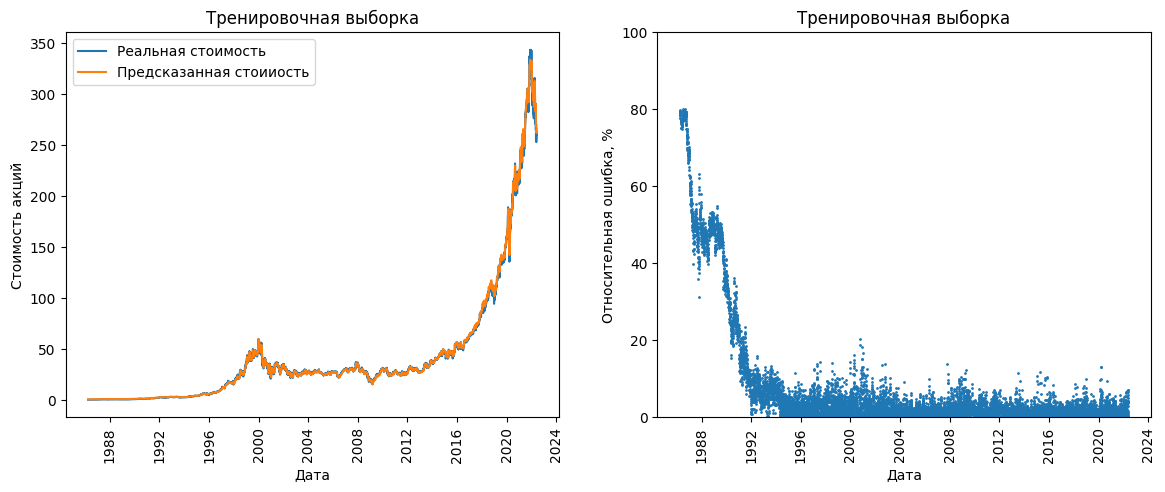

In [20]:
fig, (ax1, ax2) = plt.subplots(figsize=(14, 5), ncols=2)

ax1.plot(train_dates, new_y_train, label='Реальная стоимость')
ax1.plot(train_dates, train_predictions, label='Предсказанная стоииость')
ax1.set_title('Тренировочная выборка')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Стоимость акций')
ax1.legend()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

ax2.scatter(train_dates, abs(new_y_train-train_predictions)/train_predictions*100, s=1)
ax2.set_ylim([0, 100])
ax2.set_title('Тренировочная выборка')
ax2.set_xlabel('Дата')
ax2.set_ylabel('Относительная ошибка, %')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

plt.show()

Предсказания на тренировочной выборке хорошо согласуются с реальными данными, для более поздних дат происходит уменьшение относительной ошибки.

In [21]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0],  window+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = deepcopy(dummies[:, 0])

In [22]:
dummies = np.zeros((X_test.shape[0],  window+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = deepcopy(dummies[:, 0])

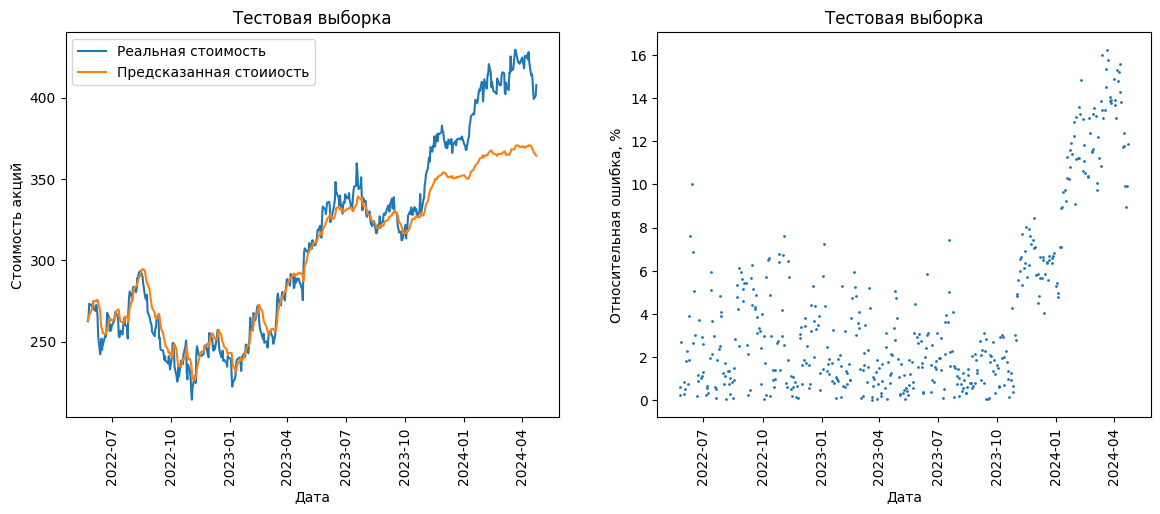

In [23]:
fig, (ax1, ax2) = plt.subplots(figsize=(14, 5), ncols=2)

ax1.plot(test_dates, new_y_test, label='Реальная стоимость')
ax1.plot(test_dates, test_predictions, label='Предсказанная стоииость')
ax1.set_title('Тестовая выборка')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Стоимость акций')
ax1.legend()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

ax2.scatter(test_dates, abs(new_y_test-test_predictions)/test_predictions*100, s=1)
ax2.set_title('Тестовая выборка')
ax2.set_xlabel('Дата')
ax2.set_ylabel('Относительная ошибка, %')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

plt.show()

Для тестовой выборки пердсказанный характер изменения стоимости акций согласуется с действительностью. Однако для более поздних дат происходит увеличение относительной ошибки, что говорит о плохой предсказательной способности на большой период (более 1 года)

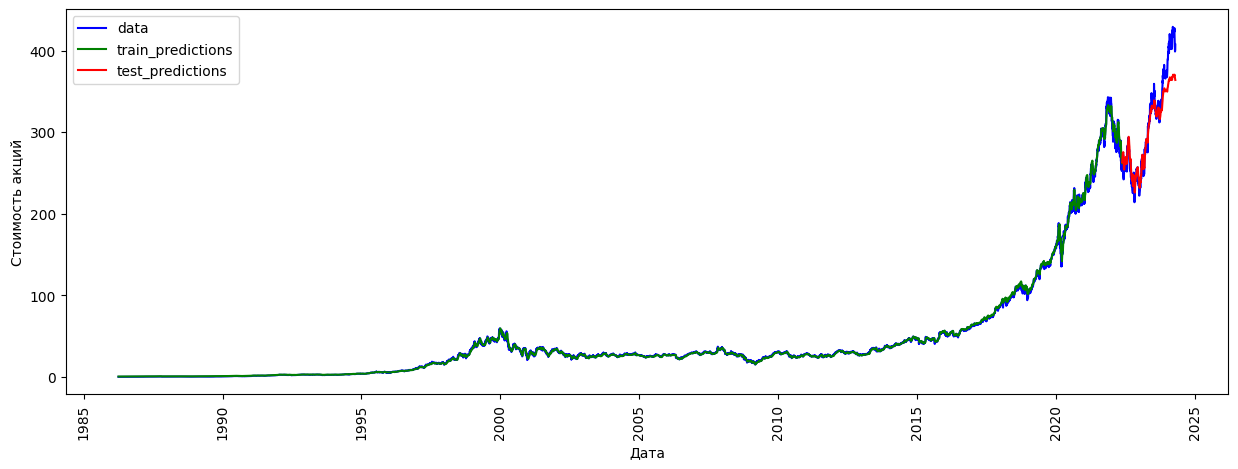

In [24]:
plt.figure(figsize=(15, 5))

plt.plot(train_dates, new_y_train, c='blue')
plt.plot(test_dates, new_y_test, c='blue', label='data')

plt.plot(train_dates, train_predictions, label='train_predictions', color='green')
plt.plot(test_dates, test_predictions, label='test_predictions', color='red')
plt.xlabel('Дата')
plt.ylabel('Стоимость акций')
plt.legend()
plt.xticks(rotation=90)
plt.show()